In [389]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
import pandas as pd
import pathlib
import sisepuede.core.support_classes as sc
import sisepuede.manager.sisepuede_file_structure as sfs
import sisepuede.manager.sisepuede_models as sm
import warnings
warnings.filterwarnings("ignore")

import common_data_needs as cdn



# Initialize some SISEPUEDE components

In [46]:
dict_ssp = cdn.setup_sisepuede_elements()

matt = dict_ssp.get("model_attributes", )
models = dict_ssp.get("models", )
regions = dict_ssp.get("regions", )
time_periods = dict_ssp.get("time_periods", )

# setup region
_REGION_NAME = "uganda"
_REGION_ISO = regions.return_region_or_iso(_REGION_NAME, return_type = "iso")

# some fields
_FIELD_CENSUS = "pop_total_ubos"
_FIELD_POP_EST_MAX = "pop_est_max"
_FIELD_POP_EST_MIN = "pop_est_min"
_FIELD_POP_EST_NOMINAL = "pop_est_nominal"
_FIELD_POP_UN_MAX = "pop_un_max"
_FIELD_POP_UN_MIN = "pop_un_min"
_FIELD_POP_URBAN_BOS = "pop_urban_bos"
_FIELD_URBANIZATION_RATE = "frac_urban"
_FIELD_URBANIZATION_RATE_EST = "frac_urban_est"

# Build urban and rural populations

<Axes: xlabel='year'>

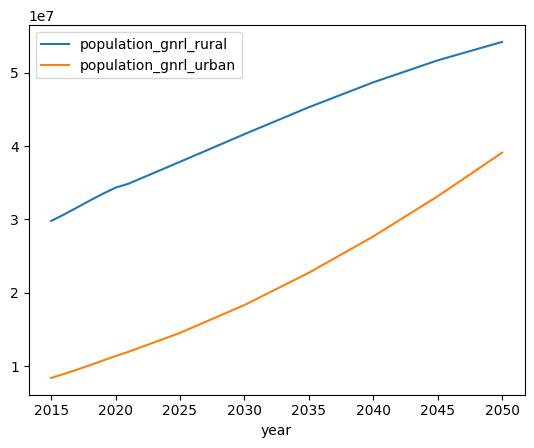

In [500]:
df_uganda = cdn.get_raw_ssp_inputs()

# get some SISEPUEDE info
attr_gnrl = matt.get_attribute_table(matt.subsec_name_gnrl)
modvar_pop = matt.get_variable(
    models.model_socioeconomic.modvar_gnrl_subpop,
)


(
    modvar_pop
    .get_from_dataframe(
        df_uganda, 
        fields_additional = [time_periods.field_year],
    )
    .plot(x = time_periods.field_year, )
)


# Adjust based off statistical abstract and census in 2014
- Census population from [Uganda BOS](https://www.ubos.org/explore-statistics/20/)

In [501]:
# get census data
fn_population_bos = "Census_Population_counts_(2002_and_2014)_by_Region,_District_and_Mid-Year_Population_projections_(2015-2021).xlsx"
path_pop = cdn._PATH_INPUTS.joinpath("ubos", fn_population_bos, )

# do some formatting
df_pop = pd.read_excel(path_pop, sheet_name = "Sheet3", skiprows = 4, )

# clean columns
vec_columns = list(df_pop.columns)
vec_columns[2] = str(df_pop.iloc[0, 2])
df_pop.columns = vec_columns

# drop
fields_drop = [
    x for x in df_pop.columns
    if (
        (
            isinstance(x, str) 
            and ("Unnamed" in x)
        )
        or (
            isinstance(x, int) 
            and x not in list(df_uganda[time_periods.field_year])
        )
    )
]


df_pop = (
    df_pop
    .drop(columns = fields_drop)
    .iloc[1:]
    .reset_index(drop = True, )
)

# Get the population from the census in a format that is comparable to Uganda data

In [502]:
df_pop_total_from_census = (
    df_pop[
        df_pop["CENTRAL"].isin(["National"])
    ]
    .drop(columns = ["CENTRAL"])
    .transpose()
    .reset_index()
)


# clean the names
field_to_rename = [x for x in df_pop_total_from_census.columns if x != "index"][0]

(
    df_pop_total_from_census
    .rename(
        columns = {
            "index": time_periods.field_year, 
            field_to_rename: _FIELD_CENSUS,
        },
        inplace = True,
    )
)

# ADD TWO VALUES FROM THE 2023 STATISTICAL ABSTRACTd
#
# See FIGURE 2.1, PROJECTED POPULATION 2018-MID 2023
df_pop_total_from_census_append = pd.DataFrame(
    {
        time_periods.field_year: [2022, 2023],
        _FIELD_CENSUS: [44200000, 45600000]
    }
)

df_pop_total_from_census = (
    pd.concat(
        [
            df_pop_total_from_census,
            df_pop_total_from_census_append
        ]
    )
    .sort_values(by = [time_periods.field_year])
    .reset_index(drop = True, )
)





# Use UN projections to 2100 to guide projections past 2040 (as well as shape to 2040)

In [511]:
path_un = pathlib.Path(
    "/Users/usuario/SISEPUEDE_DATA_REPOSITORY/UN/WPP2024_POP_F01_1_POPULATION_SINGLE_AGE_BOTH_SEXES.xlsx"
)
dict_un_table_names = pd.read_excel(
    path_un, 
    sheet_name = None, 
    nrows = 2,
)


# read in and filter
dict_un_tables = {}
fields_projections = []
field_un_year = "Year"
sheets_skip = ["NOTES"]

i = 0
for k in dict_un_table_names:
    if k in sheets_skip:
        continue
        
    df = pd.read_excel(
        path_un, 
        sheet_name = k, 
        skiprows = 16,
    )

    # filter
    df = df[
        df["ISO3 Alpha-code"].isin([_REGION_ISO])
    ]

    if len(df) == 0:
        continue

    # add the total population and extract
    fields_sum = [x for x in df.columns if str(x).isnumeric()] + ["100+"]
    df[k] = df[fields_sum].sum(axis = 1)
    
    df = (
        df[[field_un_year, k]]
        .rename(
            columns = {field_un_year: time_periods.field_year, }
        )
    )

    df[time_periods.field_year] = df[time_periods.field_year].astype(int)
    dict_un_tables.update({k: df, })
    fields_projections.append(k)

    print(f"Completed field {k}")
    
    # get total
    i += 1
    

Completed field Estimates
Completed field Medium variant
Completed field High variant
Completed field Low variant
Completed field Constant-fertility
Completed field Instant-replacement
Completed field Instant-replacement zero migr
Completed field Momentum
Completed field Zero-migration
Completed field Constant-mortality
Completed field No change
Completed field No fertility below age 18
Completed field Accelerated ABR decline
Completed field Accelarated ABR decline recup


In [512]:
dict_un_tables_safe = {}

for k, v in dict_un_tables.items():
    v2 = v.copy()
    dict_un_tables_safe.update({k: v2, })

In [513]:
# clean by adding estimates as base
key_base = "Estimates"
df_base = dict_un_tables.get(key_base)
dict_un_tables_new = {}

for k, v in dict_un_tables.items():

    # drop the stupid index
    v.reset_index(
        drop = True, 
        inplace = True, 
    )

    if k == key_base: continue

    # if missing, add in data from estimates
    df_prepend = (
        df_base[
            ~df_base[time_periods.field_year]
            .isin(v[time_periods.field_year].unique())
        ]
        .rename(columns = {key_base: k, })
    )

    v = (
        pd.concat(
            [df_prepend, v], 
            axis = 0, 
        )
        .sort_values(by = [time_periods.field_year])
        .reset_index(drop = True, )
    )
    
    dict_un_tables_new.update({k: v, })
    
dict_un_tables = dict_un_tables_new

##  Build a single df for UN projections so that we can get bounds

In [518]:
keys_un = list(dict_un_tables.keys())
df_un_projections = dict_un_tables.get(keys_un[0])

if len(keys_un) > 1:
    for k in keys_un[1:]:
        df_un_projections = pd.merge(
            df_un_projections, 
            dict_un_tables.get(k, ),
            how = "outer",
        )

# add bounds and multiply by 1000 to get real population
df_un_projections[keys_un] *= 1000 
df_un_projections[_FIELD_POP_UN_MAX] = df_un_projections[keys_un].max(axis = 1, )
df_un_projections[_FIELD_POP_UN_MIN] = df_un_projections[keys_un].min(axis = 1, )



# First, find a scalar to help align UN population projections with Uganda Census projections

In [519]:
df_un_projections_convergent = df_un_projections[
    df_un_projections[time_periods.field_year] < y_divergent
]

df_find_scalar = (
    pd.merge(
        df_un_projections_convergent[
            [
                time_periods.field_year,
                _FIELD_POP_UN_MAX,       # only need one field
            ]
        ],
        df_pop_total_from_census
    )
    .sort_values(by = [time_periods.field_year], )
)

# scale data to get best fit of UN to census estimates (NOT observations)
ratio_y0 = df_find_scalar[_FIELD_CENSUS].iloc[0]/df_find_scalar[_FIELD_POP_UN_MAX].iloc[0]
ratio_y1 = df_find_scalar[_FIELD_CENSUS].iloc[-1]/df_find_scalar[_FIELD_POP_UN_MAX].iloc[-1]
scale_factor_unpop = (ratio_y0 + ratio_y1)/2

fields_scale = keys_un + [_FIELD_POP_UN_MIN, _FIELD_POP_UN_MAX]
arr_tmp = df_un_projections[fields_scale].to_numpy()*scale_factor_unpop
df_un_projections[fields_scale] = arr_tmp

print(f"UN populations were scaled by {scale_factor_unpop}, average of {ratio_y0} and {ratio_y1}")

UN populations were scaled by 0.9415547941110876, average of 0.9459294606705203 and 0.9371801275516547


## Get information on divergence year and growth rates for each projection starting at that point

In [520]:
# get the first divergent year
for i, row in df_un_projections.iterrows():
    if len(set(row[keys_un])) > 1:
        break

# get some information about when it diverges
y_divergent = row[time_periods.field_year]
i_divergent = i

# get arrays of populations and growth rates for max/min
arr_pops = (
    df_un_projections[[_FIELD_POP_UN_MIN, _FIELD_POP_UN_MAX]]
    .iloc[i - 1:, :]
    .to_numpy()
)
arr_rates = arr_pops[1:]/arr_pops[0:-1]

# base vector to which growth rates are applied
vec_base_for_rates = df_un_projections[keys_un].iloc[i - 1].to_numpy()

In [521]:
(vec_base_for_rates[0] * np.cumprod(arr_rates, axis = 0))[16]

array([57432953.681859374, 73796038.13454133], dtype=object)

In [522]:
df_un_projections.iloc[i - 1]

year                                        2023
Medium variant                   45812856.407478
High variant                     45812856.407478
Low variant                      45812856.407478
Constant-fertility               45812856.407478
Instant-replacement              45812856.407478
Instant-replacement zero migr    45812856.407478
Momentum                         45812856.407478
Zero-migration                   45812856.407478
Constant-mortality               45812856.407478
No change                        45812856.407478
No fertility below age 18        45812856.407478
Accelerated ABR decline          45812856.407478
Accelarated ABR decline recup    45812856.407478
pop_un_max                       45812856.407478
pop_un_min                       45812856.407478
Name: 73, dtype: object

<Axes: xlabel='year'>

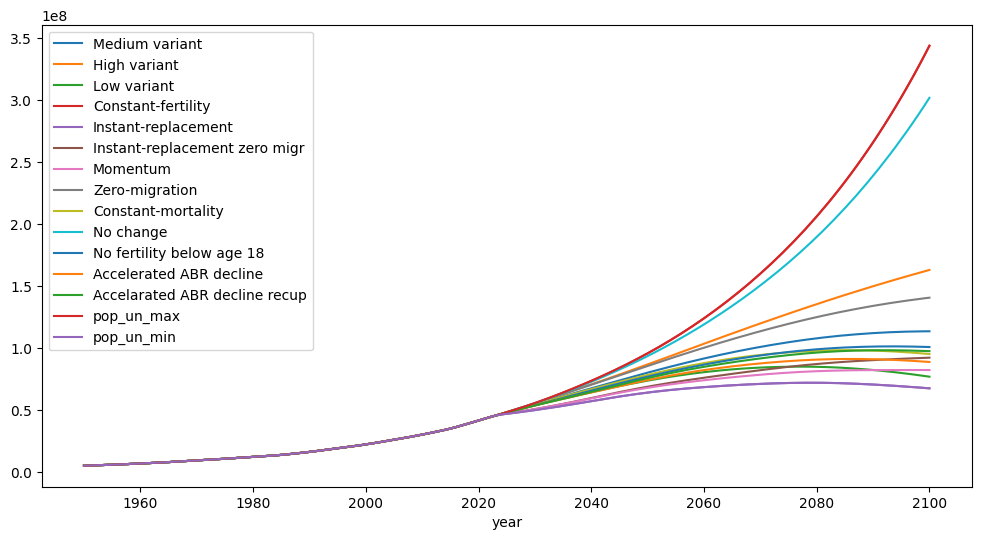

In [523]:
fig, ax = plt.subplots(figsize = (12, 6))
df_un_projections.plot(x = "year", ax = ax, )

# Now, we are going to search for populations
- NOTE: to hit the Vision 2040 high end population of 93.4 million, with a population of 45.6 million in 2023, the population would have to grow by 4.3%/year, higher than their original vision
- Furthermore, if we allow for the 3.2% growth rate from 2023 (based on current estimate of 45.6, we would find a total of 77,896,814--this is just below the UN top end projection of 73,048,952
    - We can scale up to meet this
- For the low end estimate of 61,000,000 (pg 88, paragraph 248 of Vision 2040), we find a mix between max and min that works
  

In [524]:
# scaled UN populations at 2040
series_un_2040 = df_un_projections[
    df_un_projections[time_periods.field_year].isin([2040])
].iloc[0]
series_un_2040

year                                        2040
Medium variant                   67811170.312562
High variant                     70948481.730499
Low variant                      64680823.104659
Constant-fertility               73796038.134541
Instant-replacement              57432953.681859
Instant-replacement zero migr    59961598.415475
Momentum                         59672303.351098
Zero-migration                   70678344.481517
Constant-mortality               67149193.737353
No change                        73048952.538383
No fertility below age 18        65929269.680695
Accelerated ABR decline           64434968.08304
Accelarated ABR decline recup    64859184.183195
pop_un_max                       73796038.134541
pop_un_min                       57432953.681859
Name: 90, dtype: object

In [525]:
# number of years for growth ests
n_years_exp = 2040 - y_divergent + 1
n_years_exp

17

In [526]:
# vision 2040 comparison to their own estimate
(93400000/45600000)**(1/n_years_exp)




1.0430775306910265

In [527]:
val_2040_from_gr = 45600000*((1.032)**17)   # 2023 to 2040--ind of UN data
val_2040_from_gr

77896814.23970784

In [528]:
# there's only one value in vec_base_for_rates, so we can pick an arbitrary element
ratio_top = val_2040_from_gr/series_un_2040[_FIELD_POP_UN_MAX]
scalar = ratio_top**(1/n_years_exp)


# ASSIGN TOP AND BOTTOM GROWTH RATES HERE
vec_max_gr = arr_rates[:, 1]*scalar
vec_min_gr = arr_rates[:, 0]

# verify this equivalience
np.round(vec_base_for_rates[0]*np.cumprod(vec_max_gr)[n_years_exp - 1] - val_2040_from_gr, decimals = 5)

np.float64(0.0)

## Mix the min/max to hit 61,000,000 projection in 2040 

In [529]:
# number from Vision 2040, paragraph 248, pg 88
targ_low_2040 = 61000000

proj_max = vec_base_for_rates[0]*np.cumprod(vec_max_gr)[0:n_years_exp]
proj_min = vec_base_for_rates[0]*np.cumprod(vec_min_gr)[0:n_years_exp]

mix_0 = (targ_low_2040 - proj_min[-1])/(proj_max[-1] - proj_min[-1])

# get real mix value
def est_pop(
    mix: float,
) -> float:
    """
    """
    vec_lower_v2040 = vec_max_gr*mix + vec_min_gr*(1 - mix)
    out = vec_base_for_rates[0]*np.cumprod(vec_lower_v2040)[n_years_exp - 1]

    return out

# use bifurcation method
eps = 0.05
mix_1 = mix_0 + 0.05
pop_val = est_pop(mix_0, )

while np.abs(pop_val - targ_low_2040) > eps:
    mix_candidate = (mix_0 + mix_1)/2
    pop_val = est_pop(mix_candidate, )

    if pop_val > targ_low_2040:
        mix_1 = mix_candidate
    elif pop_val < targ_low_2040:
        mix_0 = mix_candidate
    else:
        print("breaking")
        break

# build the lower end val    
vec_gr_lower_v2040 = vec_max_gr*mix_candidate + vec_min_gr*(1 - mix_candidate) 

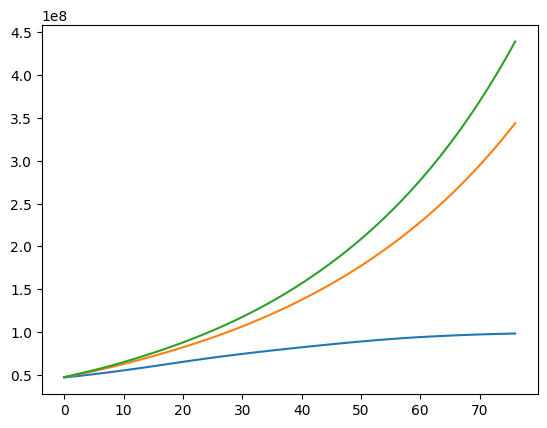

In [530]:
plt.plot(vec_base_for_rates[0]*np.cumprod(vec_gr_lower_v2040))
plt.plot(vec_base_for_rates[0]*np.cumprod(arr_rates[:,1]), )
plt.plot(vec_base_for_rates[0]*np.cumprod(vec_max_gr))

# Build DataFrame of total population projections
- We can use this to get bounds on total population

In [545]:
pop_base = vec_base_for_rates[0]
vec_pop_max = pop_base*np.cumprod(vec_max_gr)#np.insert(np.cumprod(vec_max_gr), 0, 1.0, )
vec_pop_min = pop_base*np.cumprod(vec_min_gr)
vec_pop_nominal = pop_base*np.cumprod(vec_gr_lower_v2040)


### Now, build estimated population using min, max, nominal 

In [680]:
# rename
df_estimated_population = (
    df_un_projections
    .get(
        [
            time_periods.field_year,
            _FIELD_POP_UN_MIN,
            _FIELD_POP_UN_MAX,
        ]
    )
    .rename(
        columns = {
            _FIELD_POP_UN_MIN: _FIELD_POP_EST_MIN,
            _FIELD_POP_UN_MAX: _FIELD_POP_EST_MAX,
        }
    )
)

df_estimated_population[_FIELD_POP_EST_NOMINAL] = df_estimated_population[_FIELD_POP_EST_MAX].copy()

# split and update divergent values
df_estimated_population_convergent = df_estimated_population[df_estimated_population[time_periods.field_year] < y_divergent]
df_estimated_population_divergent = df_estimated_population[df_estimated_population[time_periods.field_year] >= y_divergent]
df_estimated_population_divergent[_FIELD_POP_EST_MAX] = vec_pop_max
df_estimated_population_divergent[_FIELD_POP_EST_MIN] = vec_pop_min
df_estimated_population_divergent[_FIELD_POP_EST_NOMINAL] = vec_pop_nominal


df_estimated_population = (
    pd.concat(
        [
            df_estimated_population_convergent,
            df_estimated_population_divergent,
        ]
    )
    .sort_values(by = [time_periods.field_year])
    .reset_index(drop = True, )
)

<Axes: xlabel='year'>

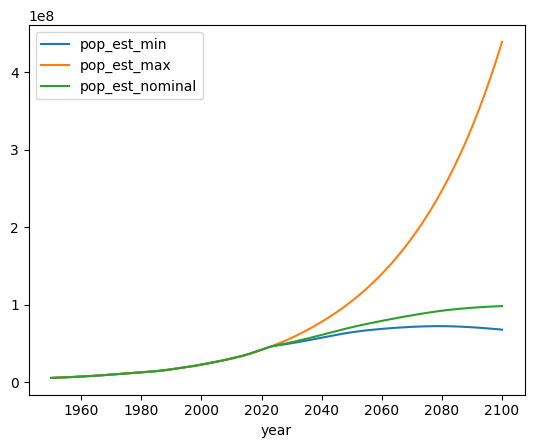

In [681]:
df_estimated_population.plot(x = time_periods.field_year, )

# Next, get urbanization estimates 

In [682]:
path_urbanization_un = pathlib.Path("/Users/usuario/SISEPUEDE_DATA_REPOSITORY/UN/WUP2018-F02-Proportion_Urban.xls")
if not path_urbanization_un.is_file():
    raise RuntimeError(f"UN Urbanization data at '{path_urbanization_un}' not found.")


In [559]:
%pip install xlrd

Note: you may need to restart the kernel to use updated packages.


In [683]:
df_urbanization_un = pd.read_excel(path_urbanization_un, skiprows = 16)
df_urbanization_un = df_urbanization_un[
    df_urbanization_un["Region, subregion, country or area"].isin(["Uganda"])
]

fields_keep = [x for x in df_urbanization_un.columns if str(x).isnumeric()]
df_urbanization_un = (
    df_urbanization_un[fields_keep]
    .transpose()
    .reset_index()
    .rename(
        columns = {"index": time_periods.field_year}
    )
)

# rename urbanization rate
_FIELD_URBANIZATION_RATE = "frac_urban"
field_rnm = [x for x in df_urbanization_un.columns if x != time_periods.field_year][0]
df_urbanization_un.rename(
    columns = {field_rnm: _FIELD_URBANIZATION_RATE, },
    inplace = True,
)

# convert to frac instead of percentage
df_urbanization_un[_FIELD_URBANIZATION_RATE] /= 100


###  The statistical abstract for 2023 has urban populations, which we can use to estimate urbanization rates in historical years
- Use **Figure 2.3: Urban Population by Census Year and Projection** (page 81, 2023 BOS Statistical Abstract)

In [684]:
df_pop_urban_bos = pd.DataFrame(
    {
        time_periods.field_year: [2014, 2020, 2021, 2022, 2023],
        _FIELD_POP_URBAN_BOS: [7.4, 10.6, 11.4, 16.5, 17]      
    }
)

df_pop_urban_bos[_FIELD_POP_URBAN_BOS] *= 1000000
df_pop_urban_bos


,year,pop_urban_bos
0,2014,7400000.0
1,2020,10600000.0
2,2021,11400000.0
3,2022,16500000.0
4,2023,17000000.0


In [685]:
df_urbaniation_rates = pd.merge(
    df_estimated_population
    .get(
        [
            time_periods.field_year,
            _FIELD_POP_EST_NOMINAL
        ]
    ),
    df_pop_urban_bos,
    how = "left"
)

# merge and fill
df_urbaniation_rates = (
    df_urbaniation_rates[
        df_urbaniation_rates[time_periods.field_year]
        .isin(
            range(
                df_pop_urban_bos[time_periods.field_year].min(),
                df_pop_urban_bos[time_periods.field_year].max() + 1,
            )
        )
    ]
    .interpolate()
)

# get estimated urbanization rate
df_urbaniation_rates[_FIELD_URBANIZATION_RATE_EST] = (
    df_urbaniation_rates[_FIELD_POP_URBAN_BOS]/df_urbaniation_rates[_FIELD_POP_EST_NOMINAL]
)

<Axes: xlabel='year'>

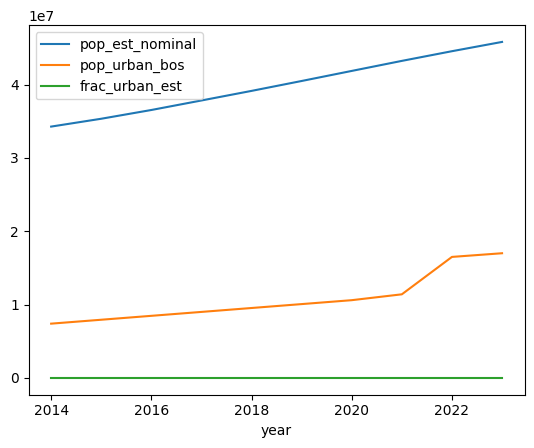

In [686]:
df_urbaniation_rates.plot(x = "year")

## Combine UN estimates of urbanization with UBOS estimates to generate a base case for urbanization rates




<Axes: xlabel='year'>

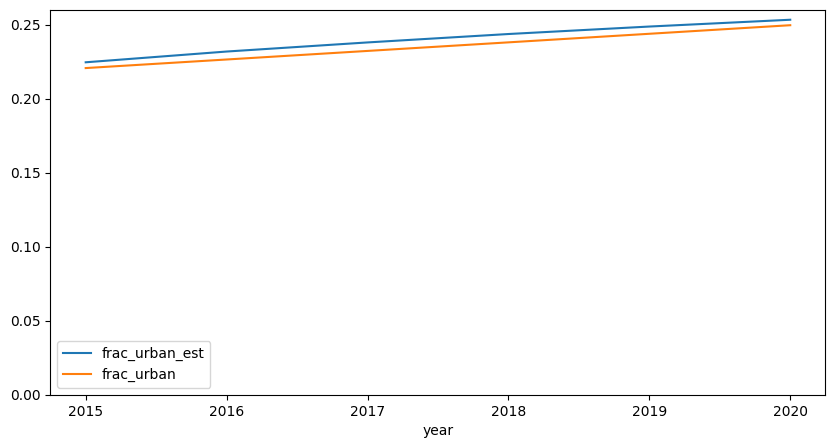

In [687]:
df_urbaniation_est = (
    pd.merge(
        df_urbaniation_rates
        .get(
            [
                time_periods.field_year,
                _FIELD_URBANIZATION_RATE_EST
            ]
        ),
        df_urbanization_un,
        how = "left",
    )
    .sort_values(by = [time_periods.field_year], )
    .interpolate(limit_area = "inside", )
    .dropna()
    .reset_index(drop = True, )
)


# look a comparison of the urbanization rates (very similar)
fig, ax = plt.subplots(figsize = (10, 5))
ax.set_ylim((0, 0.26))
df_urbaniation_est.plot(x = "year", ax = ax, )

##  Similarly to population, use a ratio between UN and UBOS to adjust UN


In [688]:

# scale data to get best fit of UN to census estimates (NOT observations)
ratio_y0_ur = df_urbaniation_est[_FIELD_URBANIZATION_RATE_EST].iloc[0]/df_urbaniation_est[_FIELD_URBANIZATION_RATE].iloc[0]
ratio_y1_ur = df_urbaniation_est[_FIELD_URBANIZATION_RATE_EST].iloc[-1]/df_urbaniation_est[_FIELD_URBANIZATION_RATE].iloc[-1]
scale_factor_un_ur = (ratio_y0_ur + ratio_y1_ur)/2


# adjust
df_urbanization_adj = df_urbanization.copy()
df_urbanization_adj[_FIELD_URBANIZATION_RATE] *= scale_factor_un_ur

<Axes: xlabel='year'>

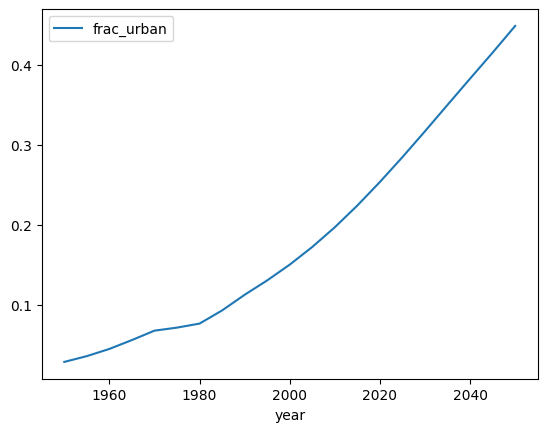

In [689]:
df_urbanization_adj.plot(x = time_periods.field_year, )

# do an estimation of urbanization rates beyond 2050
- project to 2100 sing spline--we only care about up to 2070


<Axes: xlabel='year'>

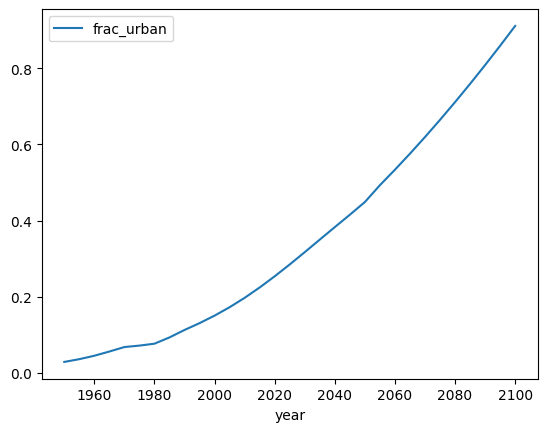

In [690]:
# project to 2100 
df_urbanization_adj = (
    pd.merge(
        pd.DataFrame(
            {
                time_periods.field_year: 1950 + np.arange(31)*5
            }
        ),
        df_urbanization_adj,
        how = "left",
    ).interpolate(
        method = "spline", 
        limit_direction = "forward", 
        order = 3,
    )
)

# verify visually
df_urbanization_adj.plot(x = time_periods.field_year, )

##  Finally, for each population trajectory, get the est urban/rural pop

In [735]:

df_est.head()

,year,pop_est_min,pop_est_max,pop_est_nominal,frac_urban
0,1950,5414800.176443,5414800.176443,5414800.176443,0.028658
1,1951,5565685.273754,5565685.273754,5565685.273754,0.030105
2,1952,5721866.146005,5721866.146005,5721866.146005,0.031552
3,1953,5884185.484736,5884185.484736,5884185.484736,0.032999
4,1954,6052670.124258,6052670.124258,6052670.124258,0.034446


In [736]:
# build a data frame for easier interpolation
df_est = (
    pd.merge(
        df_estimated_population,
        df_urbanization_adj,
        how = "left", 
    )
    .interpolate() # fill in those missing 5-year periods
)


#
fields_pop = [
    _FIELD_POP_EST_MAX,
    _FIELD_POP_EST_MIN,
    _FIELD_POP_EST_NOMINAL,
]

# split for urban and rural
df_est_urban = df_est.copy()
df_est_rural = df_est.copy()
dfs = [df_est_urban, df_est_rural]

for i, df in enumerate(dfs):
    
    arr = df[fields_pop].to_numpy().transpose()

    # get multiplier
    vec = df[_FIELD_URBANIZATION_RATE].to_numpy()
    vec = 1 - vec if i == 1 else vec

    df[fields_pop] = (arr*vec).transpose().astype(int)


# set sisepuede cats
field_cat = matt.get_subsector_attribute("General", "pycategory_primary_element")
df_est_rural[field_cat] = modvar_pop.build_fields(category_restrictions = "rural")
df_est_urban[field_cat] = modvar_pop.build_fields(category_restrictions = "urban")

df_est = pd.concat([df_est_rural, df_est_urban])


    

# Finally, set output variable for pop and build outputs
- can be used to build other trajectories and explore around population 

In [741]:
_FIELD_POP_BUILD = _FIELD_POP_EST_NOMINAL

df_piv = df_est[[time_periods.field_year, _FIELD_POP_BUILD, field_cat]]
df_piv = (
    df_piv
    .pivot(
        columns = field_cat,
        index = time_periods.field_year,
        values = _FIELD_POP_BUILD
    )
    .reset_index()
)

df_piv.columns.name = None


<Axes: xlabel='year'>

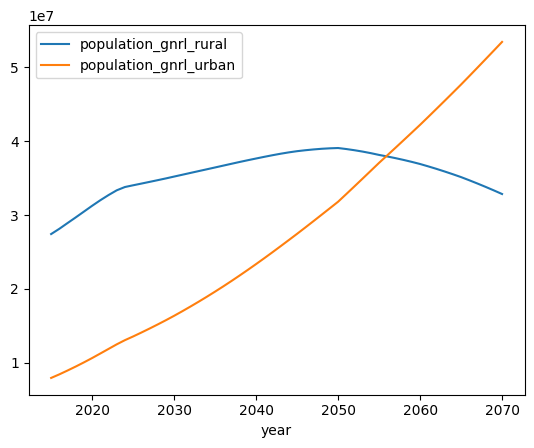

In [745]:
df_piv[
    df_piv[time_periods.field_year].isin(range(2015, 2071))
].plot(x = time_periods.field_year)

# Export

In [751]:
df_piv.to_csv(
    cdn._PATH_OUTPUTS.joinpath(f"{modvar_pop.name.upper()}.csv"),
    encoding = "UTF-8",
    index = None, 
)